In [ ]:
!pip install torcheval

In [5]:
import torchvision
from torchvision import transforms, datasets, models
import torch
from torch.nn import (
    Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax,
    BatchNorm2d, Dropout
)
from torch import optim, cuda
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import glob
from PIL import Image
from sklearn import preprocessing
from torchvision.models import VGG16_Weights
from torch.optim import Adam
from timeit import default_timer as timer

from torcheval.metrics.functional import multiclass_f1_score

# Data science tools
import numpy as np
import pandas as pd
import json

# Useful for examining network
from torchsummary import summary

# Visualizations
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
def train_model(model,criterion,optimizer,train_loader,valid_loader,save_file_name,
          max_epochs_stop=3,n_epochs=20,print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): vgg to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pth'): file path to save the model
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained vgg with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_f1_macro_max = 0

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        train_f1_score = 0
        train_f1_score_macro = 0
        valid_f1_score = 0
        valid_f1_score_macro = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()
            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)
            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)

            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)
            # Calculate f1 macro averaged score
            f1_score = multiclass_f1_score(target, pred, num_classes=6, average=None)
            train_f1_score += f1_score * data.size(0)

            f1_score_macro = multiclass_f1_score(target, pred, num_classes=6, average="macro")
            train_f1_score_macro += f1_score_macro * data.size(0)
            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            print("Start validation")
            print(
              f'{timer() - start:.2f} seconds.')
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))

                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                    # Calculate f1 macro averaged score
                    f1_score = multiclass_f1_score(target, pred, num_classes=6, average=None)
                    valid_f1_score += f1_score * data.size(0)

                    f1_score_macro = multiclass_f1_score(target, pred, num_classes=6, average="macro")
                    valid_f1_score_macro += f1_score_macro * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                # Calculate average f1 score
                train_f1_score = train_f1_score / len(train_loader.dataset)
                valid_f1_score = valid_f1_score / len(valid_loader.dataset)

                train_f1_score_macro = train_f1_score_macro / len(train_loader.dataset)
                valid_f1_score_macro = valid_f1_score_macro / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc, train_f1_score, valid_f1_score, train_f1_score_macro, valid_f1_score_macro])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )


                # Save the model if validation loss decreases
                if valid_f1_score_macro > valid_f1_macro_max:
                    # Save model
                    print('save model')
                    torch.save(model, save_file_name)

                    # Track improvement
                    epochs_no_improve = 0
                    valid_f1_macro_max = valid_f1_score_macro
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    train_loss_min = train_loss
                    train_best_acc = train_acc
                    train_f1_score_best = train_f1_score
                    valid_f1_score_best = valid_f1_score
                    train_f1_score_macro_best = train_f1_score_macro

                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model = torch.load(save_file_name)
                        # Attach the optimizer
                        model.optimizer = optimizer
                        config_model.update({'Early Stopping': 'yes', 'total_time': total_time, 'best_epoch': best_epoch, \
                                             'last_epoch': epoch, 'valid_loss_min': valid_loss_min, 'valid_best_acc': valid_best_acc, \
                                             'train_loss_min': train_loss_min, 'train_best_acc': train_best_acc, \
                                             'train_f1_score_macro_best': train_f1_score_macro_best, 'valid_f1_macro_max': valid_f1_macro_max})
                        count = 0
                        for i in valid_f1_score_best:
                          config_model.update({letters[count]:i.item()})
                          count += 1

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc', 'train_f1_score', 'valid_f1_score', 'train_f1_score_macro', 'valid_f1_score_macro'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / epoch:.2f} seconds per epoch.'
    )

    config_model.update({'Early Stopping': 'no', 'total_time': total_time, 'best_epoch': best_epoch, \
                          'last_epoch': n_epochs, 'valid_loss_min': valid_loss_min, 'valid_best_acc': valid_best_acc, \
                          'train_loss_min': train_loss_min, 'train_best_acc': train_best_acc, \
                          'train_f1_score_macro_best': train_f1_score_macro_best, 'valid_f1_macro_max': valid_f1_macro_max})
    count = 0
    for i in valid_f1_score_best:
        config_model.update({letters[count]:i.item()})
        count += 1
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc', 'train_f1_score', 'valid_f1_score', 'train_f1_score_macro', 'valid_f1_score_macro'])

    return model, history

In [8]:
def gather_png(dir_path):

    def find_matching_string(input_string, string_list):
        for string in string_list:
            if string in input_string:
                return string
        return None

    preprocess = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

    # csv files in the path
    files = glob.glob(dir_path + "/*.png")
    print(files)

    # defining an empty list to store
    # content
    content = []
    letters=['Gamma', 'Beta', 'Eta', 'Phi', 'Theta', 'Zeta']
    le = preprocessing.LabelEncoder()
    le.fit(letters)
    label_list = []

    # checking all the csv files in the
    # specified path
    for filename in files:
        matching_string = find_matching_string(filename, letters)

        # reading content of csv file
        with open(filename, 'rb') as image:
            data = Image.open(image)
            input_tensor = preprocess(data)

            content.append(input_tensor)
            if matching_string:
                label_list.append(matching_string)

    label_list = le.fit_transform(label_list)
    content = torch.stack(content)
    print('Dataset size:', content.size)
    print('Lables size:', len(label_list))

    return content, np.array(label_list, dtype=np.int32)

In [9]:
def get_pretrained_model(model_name, n_classes):

    if model_name == 'vgg16':
        model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False

        count = 0
        for i in model.classifier:
            for param in i.parameters():
                if count == 3 or count == 1:
                  param.requires_grad = True
            count += 1

        n_inputs = model.classifier[6].in_features
        config_model.update({'model': model_name, 'requires_grad(1-6)': True})

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))
        config_model.update({'model param_1': 'relu', 'model param_1': 'LogSoftmax dim=1', 'dropout': 0.2, 'classes': n_classes})

        count = 0
        for i in model.classifier:
            for param in i.parameters():
                  print(i, param.requires_grad)
            count += 1

    return model

In [11]:
train_dir_path = '/content/drive/MyDrive/deep_learning/new_split_train_val/train'
val_dir_path = '/content/drive/MyDrive/deep_learning/new_split_train_val/validation'

train_data_array, train_label_list = gather_png(train_dir_path)
val_data_array, val_label_list = gather_png(val_dir_path)

['/content/drive/MyDrive/deep_learning/new_split_train_val/train/Phi_Night_S2_32.png', '/content/drive/MyDrive/deep_learning/new_split_train_val/train/Phi_night_S2_33.png', '/content/drive/MyDrive/deep_learning/new_split_train_val/train/Phi_Night_S2_33.png', '/content/drive/MyDrive/deep_learning/new_split_train_val/train/Phi_night_S2_34.png', '/content/drive/MyDrive/deep_learning/new_split_train_val/train/Phi_Night_S2_34.png', '/content/drive/MyDrive/deep_learning/new_split_train_val/train/Phi_night_S2_35.png', '/content/drive/MyDrive/deep_learning/new_split_train_val/train/Phi_Night_S2_35.png', '/content/drive/MyDrive/deep_learning/new_split_train_val/train/Phi_night_S2_36.png', '/content/drive/MyDrive/deep_learning/new_split_train_val/train/Phi_Night_S2_36.png', '/content/drive/MyDrive/deep_learning/new_split_train_val/train/Phi_night_S2_37.png', '/content/drive/MyDrive/deep_learning/new_split_train_val/train/Phi_Night_S2_37.png', '/content/drive/MyDrive/deep_learning/new_split_train

In [12]:
#Defining the parameters
save_file_name = 'vgg16-transfer-v4q.pth'
checkpoint_path = 'vgg16-transfer.pth'

batch_size = 64
max_epochs_stop = 20
n_epochs = 100
config_model = {}
seed = 10
lr = 0.0001
letters=['Gamma', 'Beta', 'Eta', 'Phi', 'Theta', 'Zeta']
%matplotlib inline

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train = TensorDataset(train_data_array.to(device), torch.tensor(train_label_list).long().to(device))
val = TensorDataset(val_data_array.to(device), torch.tensor(val_label_list).long().to(device))

torch.manual_seed(seed)
# Dataloader iterators
dataloaders = {
    'train': DataLoader(train, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val, batch_size=batch_size, shuffle=True),
}

#To show how the data is given
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
print(features)
print(features.shape)
print(labels)
print(labels.shape)

model = get_pretrained_model('vgg16', n_classes=6)
if torch.cuda.is_available():
    model.cuda()
print(summary(model, input_size=(3, 224, 224), batch_size=batch_size))

optimizer = Adam(model.parameters(), lr=lr)
criterion = CrossEntropyLoss()

config_model.update({'save_file_name': save_file_name, 'batch_size': batch_size, 'seed': seed, 'max_epochs_stop': max_epochs_stop,\
                     'n_epochs': n_epochs, 'optimizer': 'Adam', 'lr': lr, \
                     'random_state_dataloader': 'default'})

print('before train model')
model, history = train_model(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=max_epochs_stop,
    n_epochs=n_epochs,
    print_every=1)



tensor([[[[ 0.4679,  0.4337,  0.4508,  ...,  0.6392,  0.5193,  0.4679],
          [ 0.4851,  0.4508,  0.4508,  ...,  0.2453,  0.2453,  0.2624],
          [ 0.5193,  0.4508,  0.4851,  ...,  0.3309,  0.3823,  0.3652],
          ...,
          [ 0.0056,  0.0398,  0.0569,  ..., -1.0562, -0.9363, -0.6794],
          [ 0.0056,  0.0227,  0.0569,  ..., -1.0219, -0.8849, -0.7137],
          [-0.0116,  0.0227,  0.0741,  ..., -0.9534, -0.7650, -0.6452]],

         [[ 0.5028,  0.4678,  0.5028,  ...,  0.3978,  0.1702,  0.0301],
          [ 0.5028,  0.4853,  0.5028,  ..., -0.4076, -0.5301, -0.5476],
          [ 0.5203,  0.4678,  0.5028,  ..., -0.5651, -0.5476, -0.5476],
          ...,
          [ 0.1001,  0.1352,  0.1877,  ..., -1.4755, -1.2479, -0.9153],
          [ 0.1001,  0.1527,  0.1877,  ..., -1.4405, -1.2129, -0.9503],
          [ 0.1001,  0.1527,  0.2227,  ..., -1.4405, -1.1429, -0.9153]],

         [[ 0.4439,  0.4439,  0.5311,  ...,  0.3393,  0.1128,  0.0256],
          [ 0.4439,  0.4091,  

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:23<00:00, 23.1MB/s]


Linear(in_features=25088, out_features=4096, bias=True) False
Linear(in_features=25088, out_features=4096, bias=True) False
Linear(in_features=4096, out_features=4096, bias=True) True
Linear(in_features=4096, out_features=4096, bias=True) True
Sequential(
  (0): Linear(in_features=4096, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=6, bias=True)
  (4): LogSoftmax(dim=1)
) True
Sequential(
  (0): Linear(in_features=4096, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=6, bias=True)
  (4): LogSoftmax(dim=1)
) True
Sequential(
  (0): Linear(in_features=4096, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=6, bias=True)
  (4): LogSoftmax(dim=1)
) True
Sequential(
  (0): Linear(in_features=4096, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inpla

Start validation
12.08 seconds.



Epoch: 0 	Training Loss: 1.1264 	Validation Loss: 0.8691
		Training Accuracy: 64.75%	 Validation Accuracy: 67.94%
save model


Start validation
11.97 seconds.



Epoch: 1 	Training Loss: 0.3160 	Validation Loss: 1.0106
		Training Accuracy: 91.43%	 Validation Accuracy: 63.67%


Start validation
12.17 seconds.



Epoch: 2 	Training Loss: 0.1679 	Validation Loss: 0.7371
		Training Accuracy: 95.14%	 Validation Accuracy: 73.72%
save model


Start validation
12.44 seconds.



Epoch: 3 	Training Loss: 0.0962 	Validation Loss: 0.8953
		Training Accuracy: 97.22%	 Validation Accuracy: 70.94%


Start validation
12.82 seconds.



Epoch: 4 	Training Loss: 0.0795 	Validation Loss: 1.1388
		Training Accuracy: 97.74%	 Validation Accuracy: 67.56%


Start validation
12.83 seconds.



Epoch: 5 	Training Loss: 0.0542 	Validation Loss: 0.9804
		Training Accuracy: 98.48%	 Validation Accuracy: 69.72%


Start validation
12.65 seconds.



Epoch: 6 	Training Loss: 0.0449 	Validation Loss: 1.0484
		Training Accuracy: 98.63%	 Validation Accuracy: 69.67%


Start validation
12.57 seconds.



Epoch: 7 	Training Loss: 0.0426 	Validation Loss: 1.0306
		Training Accuracy: 98.74%	 Validation Accuracy: 71.28%


Start validation
12.77 seconds.



Epoch: 8 	Training Loss: 0.0352 	Validation Loss: 1.0193
		Training Accuracy: 98.81%	 Validation Accuracy: 71.28%


Start validation
12.82 seconds.

Epoch: 9 	Training Loss: 0.0288 	Validation Loss: 1.0013
		Training Accuracy: 99.22%	 Validation Accuracy: 70.67%


Start validation
12.77 seconds.



Epoch: 10 	Training Loss: 0.0280 	Validation Loss: 1.2786
		Training Accuracy: 99.11%	 Validation Accuracy: 67.00%


Start validation
12.68 seconds.



Epoch: 11 	Training Loss: 0.0252 	Validation Loss: 1.1997
		Training Accuracy: 99.41%	 Validation Accuracy: 68.06%


Start validation
12.82 seconds.

Epoch: 12 	Training Loss: 0.0224 	Validation Loss: 1.2319
		Training Accuracy: 99.41%	 Validation Accuracy: 67.17%


Start validation
12.79 seconds.



Epoch: 13 	Training Loss: 0.0134 	Validation Loss: 1.2337
		Training Accuracy: 99.70%	 Validation Accuracy: 68.89%
Start validation
12.68 seconds.



Epoch: 14 	Training Loss: 0.0173 	Validation Loss: 1.2605
		Training Accuracy: 99.41%	 Validation Accuracy: 69.83%


Start validation
12.81 seconds.



Epoch: 15 	Training Loss: 0.0145 	Validation Loss: 1.2540
		Training Accuracy: 99.59%	 Validation Accuracy: 66.83%


Start validation
12.81 seconds.



Epoch: 16 	Training Loss: 0.0175 	Validation Loss: 1.4886
		Training Accuracy: 99.48%	 Validation Accuracy: 64.61%


Start validation
12.82 seconds.



Epoch: 17 	Training Loss: 0.0130 	Validation Loss: 1.5101
		Training Accuracy: 99.70%	 Validation Accuracy: 64.94%


Start validation
12.81 seconds.



Epoch: 18 	Training Loss: 0.0081 	Validation Loss: 1.4322
		Training Accuracy: 100.00%	 Validation Accuracy: 66.72%


Start validation
12.82 seconds.



Epoch: 19 	Training Loss: 0.0098 	Validation Loss: 1.3771
		Training Accuracy: 99.85%	 Validation Accuracy: 67.11%


Start validation
12.75 seconds.



Epoch: 20 	Training Loss: 0.0177 	Validation Loss: 1.5232
		Training Accuracy: 99.48%	 Validation Accuracy: 63.83%


Start validation
12.70 seconds.



Epoch: 21 	Training Loss: 0.0135 	Validation Loss: 1.2817
		Training Accuracy: 99.55%	 Validation Accuracy: 67.56%


Start validation
12.72 seconds.



Epoch: 22 	Training Loss: 0.0143 	Validation Loss: 1.5963
		Training Accuracy: 99.59%	 Validation Accuracy: 64.06%

Early Stopping! Total epochs: 22. Best epoch: 2 with loss: 0.74 and acc: 73.72%
481.50 total seconds elapsed. 20.93 seconds per epoch.


In [14]:
config_model

{'model': 'vgg16',
 'requires_grad(1-6)': True,
 'model param_1': 'LogSoftmax dim=1',
 'dropout': 0.2,
 'classes': 6,
 'save_file_name': 'vgg16-transfer-v4q.pth',
 'batch_size': 64,
 'seed': 10,
 'max_epochs_stop': 20,
 'n_epochs': 100,
 'optimizer': 'Adam',
 'lr': 0.0001,
 'random_state_dataloader': 'default',
 'Early Stopping': 'yes',
 'total_time': 481.50298506299987,
 'best_epoch': 2,
 'last_epoch': 22,
 'valid_loss_min': 0.7371321341726516,
 'valid_best_acc': 0.7372222222222222,
 'train_loss_min': 0.16790232194487373,
 'train_best_acc': 0.9513914656771799,
 'train_f1_score_macro_best': tensor(0.9486, device='cuda:0'),
 'valid_f1_macro_max': tensor(0.7257, device='cuda:0'),
 'Gamma': 0.8707758188247681,
 'Beta': 0.6177555918693542,
 'Eta': 0.9260326027870178,
 'Phi': 0.6787493228912354,
 'Theta': 0.6839557886123657,
 'Zeta': 0.5708982944488525}

In [15]:
config_model['train_f1_score_macro_best'] = config_model['train_f1_score_macro_best'].item()
config_model['valid_f1_macro_max'] = config_model['valid_f1_macro_max'].item()

In [16]:
json_object = json.dumps(config_model, indent=4)

# Writing to sample.json
with open("model_configuration_v4q.json", "w") as outfile:
    outfile.write(json_object)

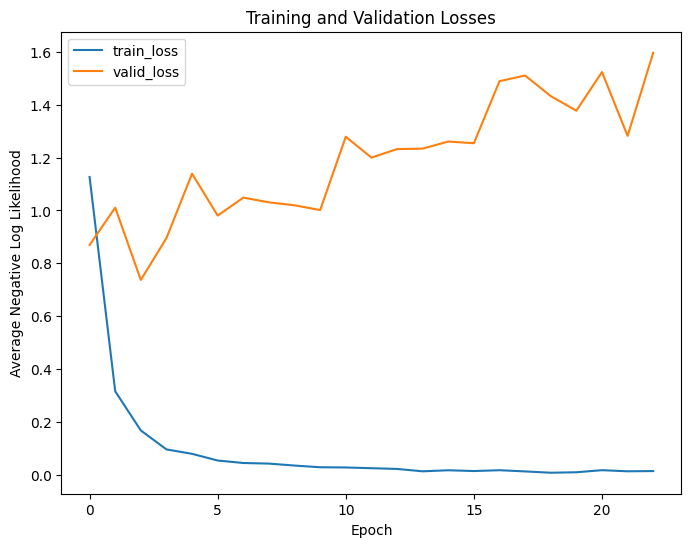

In [17]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.savefig('loss.png')



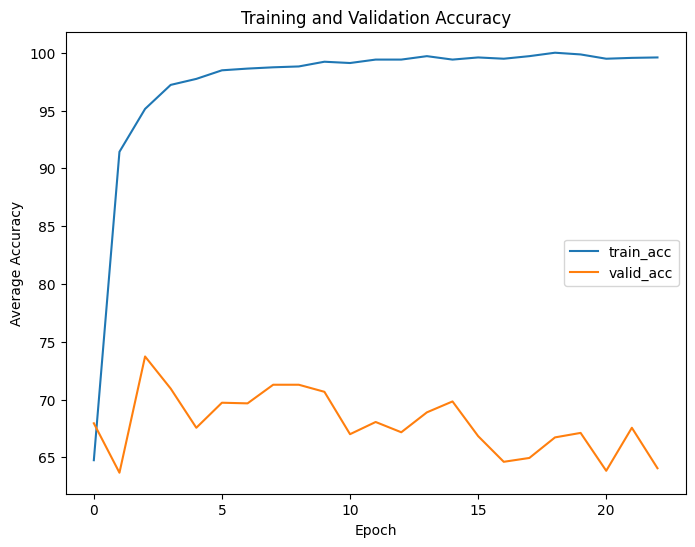

In [18]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

plt.savefig('accuracy.png')


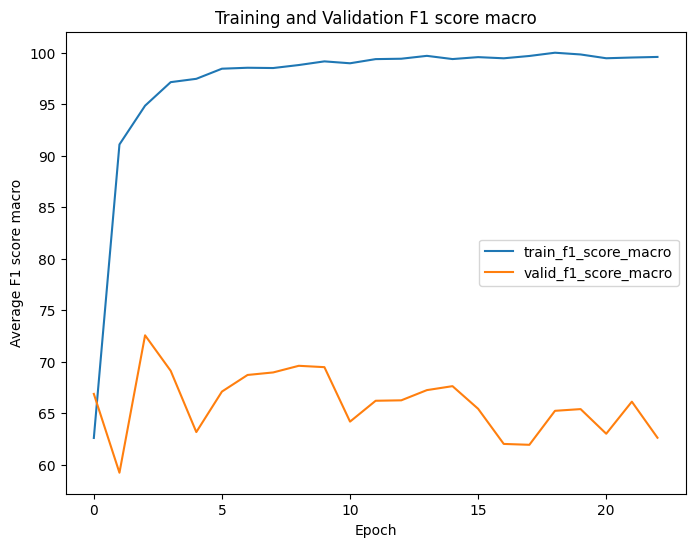

In [19]:
plt.figure(figsize=(8, 6))
for c in ['train_f1_score_macro', 'valid_f1_score_macro']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average F1 score macro')
plt.title('Training and Validation F1 score macro')

plt.savefig('f1_macro.png')
